# Delayed Self-Heterodyne Phase Noise Measurements With Coherent Phase Modulation Detection

This notebook focuses on metodologies presented in the work: 

[Delayed Self-Heterodyne Phase Noise Measurements With Coherent Phase Modulation Detection (2012)](https://ieeexplore.ieee.org/document/6064871)


I am starting with this work, because it study a system with only one laser

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from optic.models.devices import photodiode, basicLaserModel
from optic.dsp.core import phaseNoise
from optic.models.amplification import OSA, get_spectrum
from optic.utils import parameters
from optic.plot import plotPSD
from scipy.constants import c
from scipy.signal import hilbert
from scipy.signal.windows import hamming
from IPython.display import display, Math

fontSmall = {'family':'serif', 'weight':'normal', 'size':12}
font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

# DFB Semiconductor Laser Simulation using Python

This Python script simulates the behavior of a distributed feedback (DFB) semiconductor laser.
It models the laser dynamics, output power over time, and optical spectrum.
The simulation is based on a set of differential equations and numerical methods.

Author: Mohammed Mehdi Bouchene 
(https://github.com/Bouchenemehdi24/DFB-Semiconductor-Laser-Simulation-using-Python-and-Numba)

References:
1. Bouchene, M. M., & Hamdi, R. (2018). The effect of facets reflectivity on the static characteristics of (DFB) semiconductor laser.
   In 2018 International Conference on Electrical Sciences and Technologies in Maghreb (CISTEM) (pp. 1-4). IEEE.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift
from numba import jit



# Define laser Material and structure parameters
c = 3e10  # velocity of light in free space
q = 1.602e-19  # electron charge
h0 = 6.626e-34  # planck
wl = 1.55e-4  # reference lasing wavelength (cm?)
f0 = c / wl
gratingperiod = 242.1875e-7  # Grating period (cm) 2*3.2*242.1875e-3um=1.55um
L = 600e-4  # Laser length (cm)
d = 0.2e-4  # Thickness (cm)
w = 1.5e-4  # Width (cm)
V = L * d * w  # active region Volume (cm^3)
gama = 0.3  # Confinement factor
neff = 3.2  # Effective index without injection
ng = 3.6  # Group index
vg = c / ng  # group velocity
a = 10  # Internal loss (cm^-1)
gN = 2.5e-16  # Differential gain (cm^2)
NO = 1e18  # Transparent carrier density (cm^-3)
e = 5e-17  # Non-linear gain saturation coefficient (cm^3)
am = 4  # Linewidth enhancement factor
A = 0.1e9  # Linear recombination coefficient (s^-1)
B = 1e-10  # Bimolecular radiation coefficient (cm^3*s^-1)
C = 7.5e-29  # Auger coefficient (cm^-6*s^-1)
b = 5e-5  # Spontaneous emission coefficient
K = 1  # Transverse Peterman factor


# Left and right facets parameters
# HR facet
# left facet power reflectivity

rl = 0.9
rr = 0.1

# Computing parameters
M = 60  # SPACE mesh number
T = 5e-9  # 5ns
deltz = L / M  # space step
deltt = deltz / vg
tnum = round(T / deltt)  # total time step

sinto = np.ones(M)
costo = np.ones(M)


# Drive current
D = 50
I = D * 0.001


kapa = 150 * L
# set initial field and power and carrier density

F = np.zeros(M + 1, dtype=complex)
R = np.zeros(M + 1, dtype=complex)


Ft = np.zeros(tnum, dtype=complex)
Rt = np.zeros(tnum, dtype=complex)
S = np.zeros(M)
S1 = np.zeros((3, M))
N = np.ones(M) * NO
PO = np.zeros(tnum)
POO = np.zeros(tnum)
lamda_t = np.zeros(tnum)
sn1 = 1

![Heterodyne Setup](IlustrationMedia/LaserCavity_MSections.png)

The optical fields (propagation and backpropagation) are defined as: $$\begin{cases} \frac{1}{v_g}\frac{\partial E^+}{\partial t}+\frac{\partial E^+}{\partial z} = \text{gain and loss terms} + \zeta^+(z,t) \\ \frac{1}{v_g}\frac{\partial E^-}{\partial t}-\frac{\partial E^-}{\partial z} = \text{gain and loss terms} + \zeta^-(z,t) \end{cases}$$

where $v_g$ is the **group velocity** in the active medium and $\zeta^+$ and $\zeta^-$ are the **Spontaneous Emission Noise** terms associated with forward and backward traveling waves. The correlation function is defined as follows: $$\langle \zeta(z,t),\zeta^*(z',t') \rangle = K \Gamma_{sp} b R_{sp} L \delta(t-t') \delta(z-z') / v_g^2$$
Where $\Gamma_{sp}$ is the **Spontaneous emission confinement factor**, $K$ is the **Peterman factor**, $L$ is the **cavity length**, $b$ is the **Spontaneous emission coefficient**, and $R_{sp}$ is the **spontaneous emission rate**. The delta diracs guarantee that the white noise is present in both space and time



Spontaneus Emission Noise: $$\zeta = \sqrt{\frac{b \cdot \Gamma_{sp} \cdot K \cdot B \cdot N^2}{\Delta z \cdot v_g}}$$ 
where $B$ is the **bimolecular radiation coefficient**, $N$ is the **carrier density**, and $\Delta z$ is the **simulation longitudinal step**.

C:\Users\caior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\caior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 640x480 with 0 Axes>

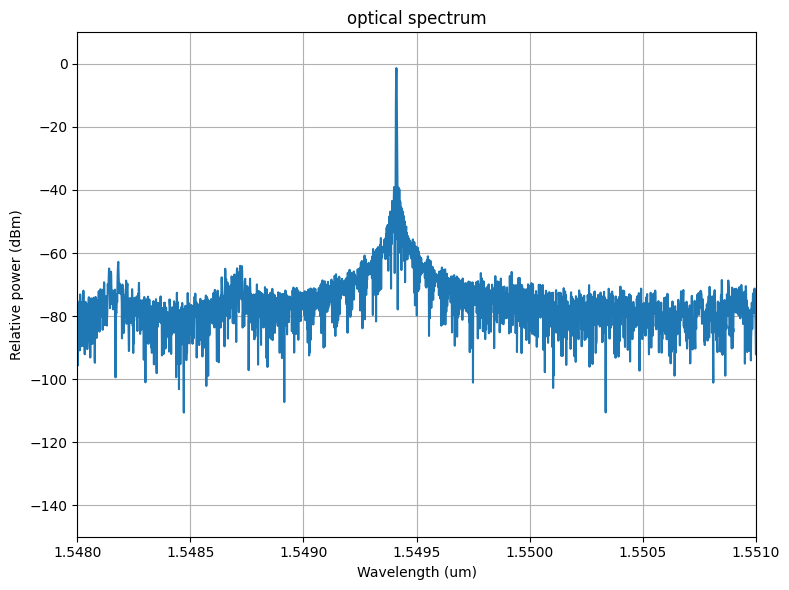

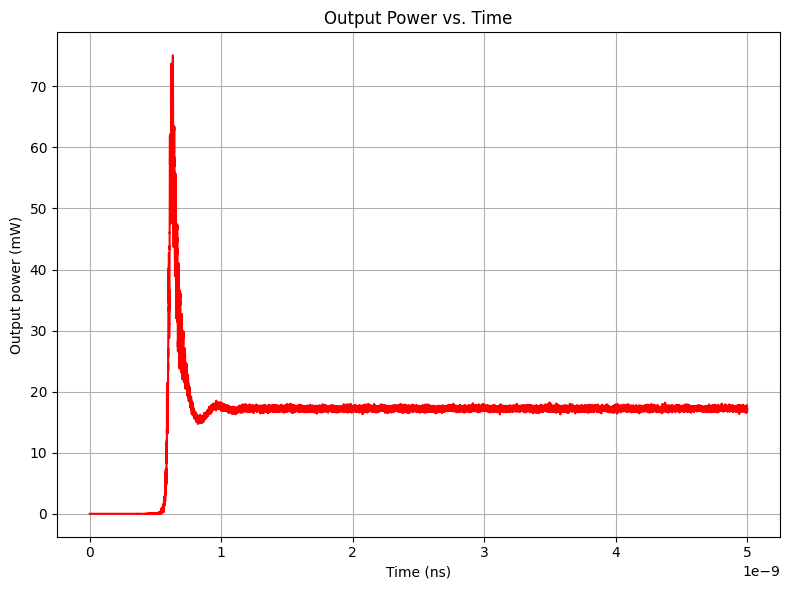

In [12]:
@jit(nopython=True)

def main_program(tnum, S1, F, R, Ft, Rt, S, N, PO, POO, lamda_t):

    # MAIN program
    for tn in range(tnum):  # building up fields over tnum time steps
        S1[0, :] = S

        # Net optical gain (ref. equation 4)
        G = 0.5 * (gama * gN * (N - NO) / (1 + e * S) - a) 
        
        # Detuning factor (ref. equation 6 applied on ref. equation 7)
        Detu = 2 * np.pi * (neff - am * gama * gN * (N - NO) * wl / (4 * np.pi * (1 + e * S))) / wl - np.pi / gratingperiod

        Spn = np.sqrt(np.abs(b * gama * K * B * N ** 2 / (deltz * vg)))
        a1 = np.random.randn(M)
        b1 = 2 * np.pi * np.random.rand(M)
        Spn1 = sn1 * Spn * a1 * np.exp(1j * b1)  # set up for random forward and backward spontaneous input

        # MAIN GUTS FOR UPDATING FIELDS and adding in spontaneous emission
        temp_f = np.exp((G - 1j * Detu) * deltz) * F[:-1] + deltz * Spn1
        temp_r = np.exp((G - 1j * Detu) * deltz) * R[1:] + deltz * Spn1
        F[0] = rl * R[0]
        R[-1] = rr * F[-1]

        F[1:] = np.cosh(kapa * deltz) * temp_f * costo - 1j * np.sinh(kapa * deltz) * temp_r * costo
        R[:-1] = -1j * np.sinh(kapa * deltz) * temp_f * sinto + np.cosh(kapa * deltz) * temp_r * sinto

        # photon density
        S = 0.5 * (np.abs(F[:-1]) ** 2 + np.abs(R[:-1]) ** 2) + 0.5 * (np.abs(F[1:]) ** 2 + np.abs(R[1:]) ** 2)

        S1[1, :] = S
        S1[2, :] = 0.5 * (S1[0, :] + S1[1, :])

        # carrier distribution
        N = N + (I / (q * V) - A * N - B * N ** 2 - C * N ** 3 - vg * gN * (N - NO) * S / (1 + e * S)) * deltt

        # OUTPUT RELATIONSHIPS
        PO[tn] = np.abs(F[-1]) ** 2 * V * vg * h0 * c * (1 - rr ** 2) / (wl * L * gama)  # right hand side's output power
        Ft[tn] = F[-1]

        POO[tn] = np.abs(R[-1]) ** 2 * V * vg * h0 * c * (1 - rl ** 2) / (wl * L * gama)  # Left hand side's output power
        Rt[tn] = R[-1]

        lamda_t[tn] = 2 * gratingperiod * (-wl * am * gama * gN * ((N[-1] - NO)) / 4 / np.pi)

main_program(tnum, S1, F, R, Ft, Rt, S, N, PO, POO, lamda_t)


Ftt = Ft[tnum - round(4e-9 / deltt):tnum]
NFFT = 2**np.ceil(np.log2(len(Ftt)))
fs = 1 / deltt
Yy = fftshift(fft(Ftt * np.hamming(len(Ftt)), int(NFFT)))

magy = Yy * np.conj(Yy) / NFFT
my = len(Yy)
fy = np.arange(-my / 2, my / 2) * fs / my
wave2 = (c / (fy + f0)) * 10**4  # um


plt.figure()
waveshape = magy[0:my] / np.max(magy)
plt.figure(figsize=(8, 6))
plt.plot(wave2, 10 * np.log10(magy[0:my] / np.max(magy)))
plt.xlabel('Wavelength (um)')
plt.ylabel('Relative power (dBm)')

plt.title('optical spectrum')

plt.grid(True)

plt.axis([1.530, 1.570, -150, 10])
# plt.xlim([1.530, 1.570])
plt.xlim([1.548, 1.551])
plt.tight_layout()

for xx in range(tnum - 1):
    PO[xx] = 0.5 * (PO[xx] + PO[xx + 1])

ORight = PO[1:tnum - 1] * 1000
ttt = np.arange(1, tnum - 1) * deltt

plt.figure(figsize=(8, 6))
plt.plot(ttt, ORight, 'r')  # mW
plt.xlabel('Time (ns)')
plt.ylabel('Output power (mW)')
plt.title('Output Power vs. Time')
plt.grid(True)
plt.tight_layout()